In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
with open('../data/expression/expressed.names') as infile:
    finz_znfs = [line.strip() for line in infile]

expression_df = pd.read_csv('../data/expression/White2017_expression_tpm.tsv',
                            sep='\t',
                            skiprows=4).fillna(0.0)
devstages = list(expression_df.columns)[2:]
melted_expression_df = expression_df.melt(id_vars=['Gene ID', 'Gene Name'], var_name='Stage', value_name='TPM')
print(melted_expression_df.head())

              Gene ID  Gene Name   Stage    TPM
0  ENSDARG00000000001    slc35a5  zygote    2.0
1  ENSDARG00000000002     ccdc80  zygote    0.3
2  ENSDARG00000000018       nrf1  zygote    7.0
3  ENSDARG00000000019      ube2h  zygote  144.0
4  ENSDARG00000000068  slc9a3r1a  zygote   42.0


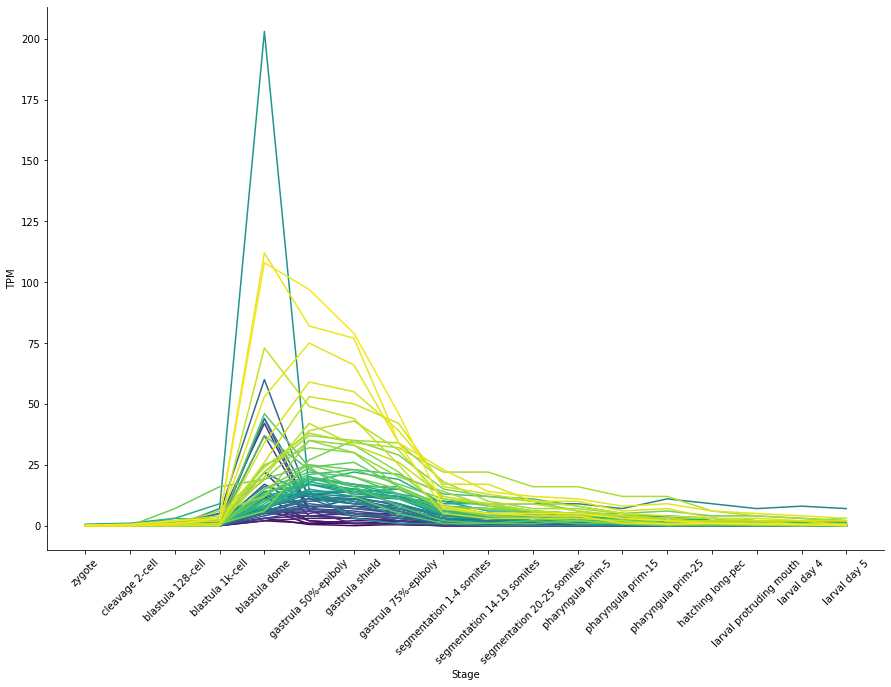

In [78]:
hue_order = melted_expression_df.loc[(melted_expression_df.Stage == 'gastrula 50%-epiboly') &
                              (melted_expression_df['Gene ID'].isin(finz_znfs))] \
    .sort_values('TPM')['Gene ID'] \
    .to_list()

fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=melted_expression_df.loc[melted_expression_df['Gene ID'].isin(finz_znfs)],
             x='Stage', 
             y='TPM', 
             hue='Gene ID',
             sort=False,
             palette='viridis',
             hue_order=hue_order)

sns.despine()
plt.xticks(rotation=45)
ax.get_legend().remove()

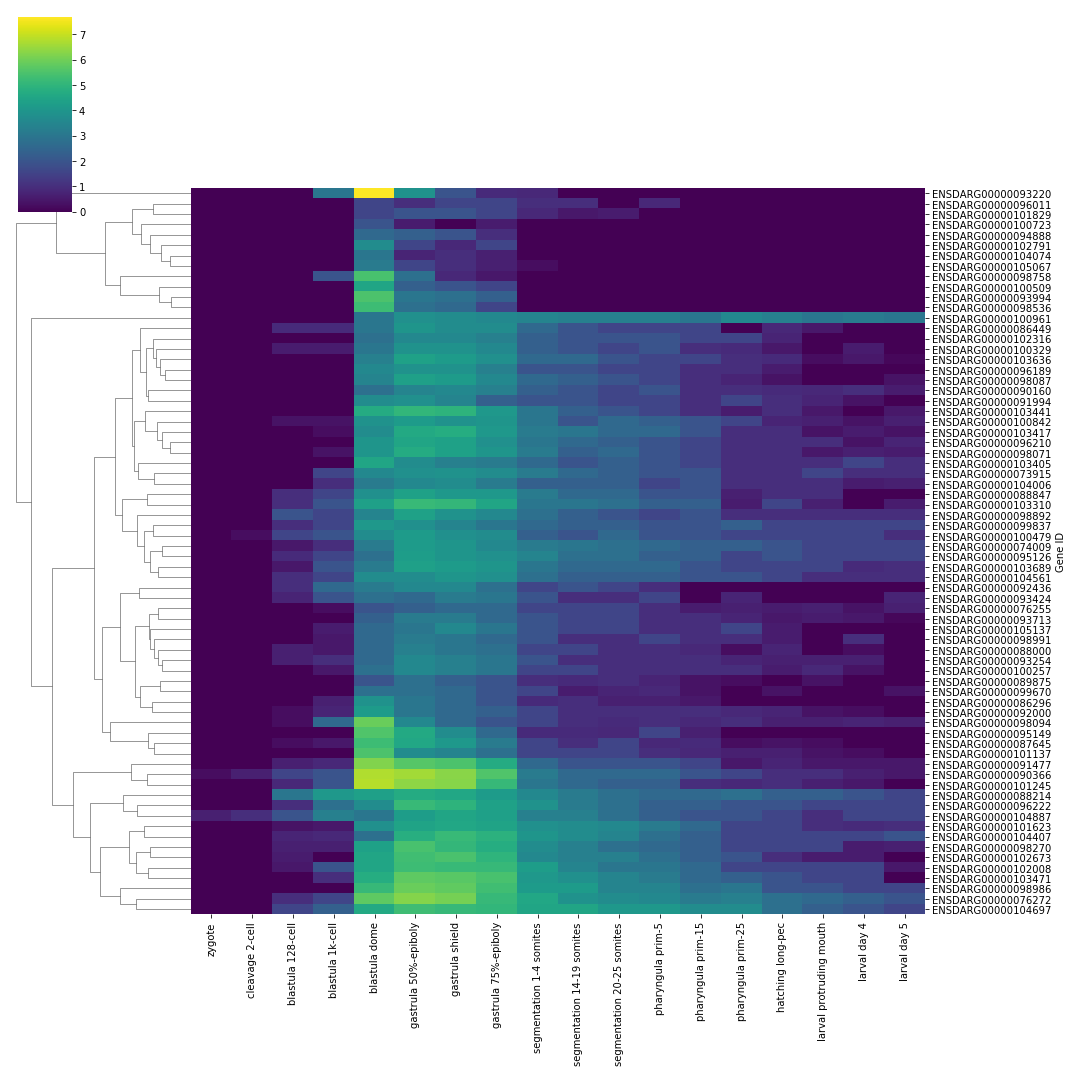

In [123]:
finz_matrix = expression_df.loc[expression_df['Gene ID'].isin(finz_znfs)].drop('Gene Name', axis=1).set_index('Gene ID')
finz_matrix = np.log2(finz_matrix + 1)

# fig, ax = plt.subplots(figsize=(15, 10))
sns.clustermap(data=finz_matrix, cmap="viridis", col_cluster=False, figsize=(15,15), yticklabels=True)
plt.show()

In [130]:
print(expression_df.loc[expression_df['Gene ID'].isin(['ENSDARG00000091477', 'ENSDARG00000090366', 'ENSDARG00000101245'])])

                  Gene ID Gene Name  zygote  cleavage 2-cell  \
17142  ENSDARG00000090366   znf1065     0.2              0.6   
17449  ENSDARG00000091477   znf1066     0.0              0.0   
21800  ENSDARG00000101245   znf1063     0.0              0.0   

       blastula 128-cell  blastula 1k-cell  blastula dome  \
17142                2.0               3.0          108.0   
17449                0.6               0.8           73.0   
21800                0.8               3.0          112.0   

       gastrula 50%-epiboly  gastrula shield  gastrula 75%-epiboly  \
17142                  97.0             79.0                  46.0   
17449                  49.0             44.0                  25.0   
21800                  82.0             77.0                  34.0   

       segmentation 1-4 somites  segmentation 14-19 somites  \
17142                       8.0                         5.0   
17449                       5.0                         3.0   
21800                       